### Условие задачи
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')


df_arc <b>Данные об электродах

In [3]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [4]:
df_arc.columns = ['key','start','end','active_power','reactive_power']

In [5]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key               14876 non-null int64
start             14876 non-null object
end               14876 non-null object
active_power      14876 non-null float64
reactive_power    14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
df_arc['start'] = pd.to_datetime(df_arc['start'], format='%Y-%m-%dT%H:%M:%S')
df_arc['end'] = pd.to_datetime(df_arc['end'], format='%Y-%m-%dT%H:%M:%S')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fddebba7cd0>,
      dtype=object)

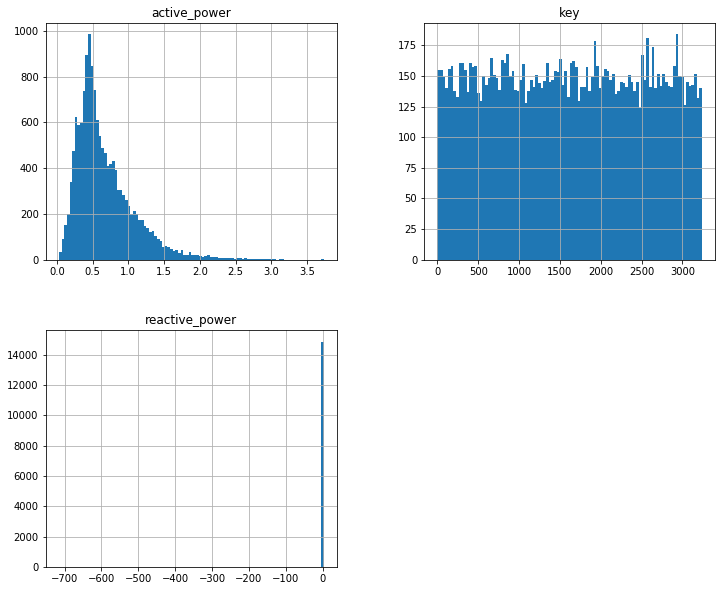

In [7]:
#В данных по реактивной ошибка, избавимся от неё
df_arc.hist(figsize = (12,10), bins= 100)

In [8]:
df_arc['active_power'].max() 

3.7315961123

In [9]:
#Нашли ошибку. Заменем её на похожую по активной мощности. 
df_arc['reactive_power'].min()

-715.5049241780998

In [10]:
#Найдем похожие реактивные мощности по активной.  
df_arc_2 = df_arc.query('0.50 >= active_power >= 0.48 ')
df_arc_2

,key,start,end,active_power,reactive_power
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
10,3,2019-05-03 12:13:52,2019-05-03 12:15:56,0.484206,0.312100
105,23,2019-05-04 05:12:31,2019-05-04 05:14:55,0.486127,0.401958
106,23,2019-05-04 05:21:29,2019-05-04 05:23:46,0.483416,0.322120
119,25,2019-05-04 06:56:28,2019-05-04 06:58:15,0.486050,0.332617
...,...,...,...,...,...
14813,3227,2019-08-31 16:51:01,2019-08-31 16:53:25,0.487348,0.356412
14828,3230,2019-08-31 19:07:40,2019-08-31 19:09:30,0.496280,0.337348
14829,3231,2019-08-31 19:19:30,2019-08-31 19:21:27,0.491337,0.373855
14861,3239,2019-09-01 01:43:37,2019-09-01 01:45:48,0.486958,0.315940


In [11]:
#Уберем ошибочное значение поменяв на похожую реактивную мощность
df_arc['reactive_power'] = df_arc['reactive_power'].replace(-715.5049241780998, 0.373854) 

df_bulk <b> Данные о подаче сыпучих материалов (объем).

In [12]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [13]:
df_bulk = df_bulk.fillna(0)

In [14]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     3129 non-null float64
Bulk 2     3129 non-null float64
Bulk 3     3129 non-null float64
Bulk 4     3129 non-null float64
Bulk 5     3129 non-null float64
Bulk 6     3129 non-null float64
Bulk 7     3129 non-null float64
Bulk 8     3129 non-null float64
Bulk 9     3129 non-null float64
Bulk 10    3129 non-null float64
Bulk 11    3129 non-null float64
Bulk 12    3129 non-null float64
Bulk 13    3129 non-null float64
Bulk 14    3129 non-null float64
Bulk 15    3129 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fddebad2510>,
      dtype=object)

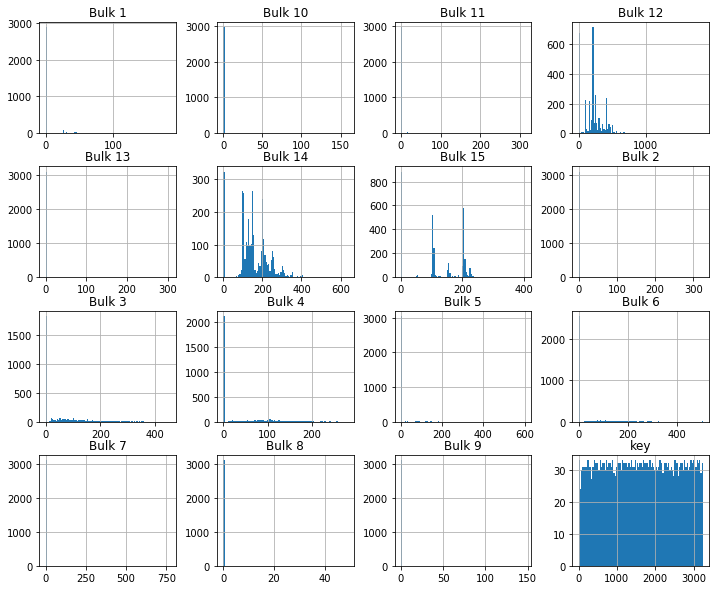

In [15]:
df_bulk.hist(figsize = (12,10), bins= 100)

<b>С большой вероятностью прпоуски озночают, что в это время в сплав ничего не сыпали вполне логично будет заменить значения на ноль

df_bulk_time <b> Данные о подаче сыпучих материалов (время).

In [16]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [17]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


df_gas <b> Данные о продувке сплава газом.

In [18]:
df_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [19]:
df_gas.columns = ['key', 'gas_1']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdde878ce10>,
      dtype=object)

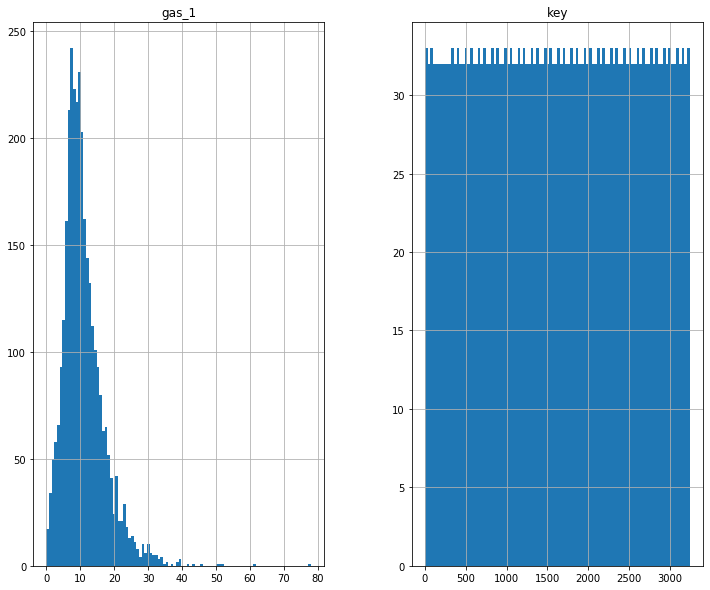

In [20]:
df_gas.hist(bins=100, figsize=(12,10))

In [21]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
gas_1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


df_temp <b> Результаты измерения температуры 

In [22]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [23]:
df_temp.columns = ['key','time','temp']

In [24]:
df_temp['time'] = pd.to_datetime(df_temp['time'], format='%Y-%m-%dT%H:%M:%S')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdde76e6050>,
      dtype=object)

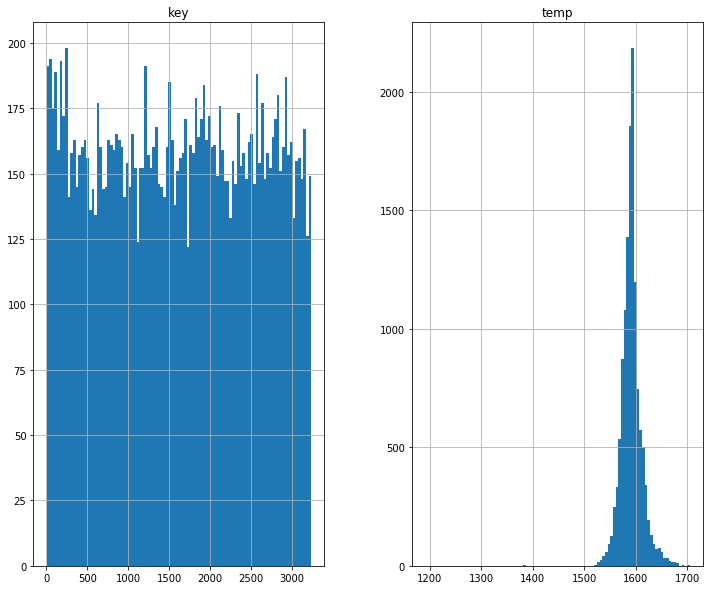

In [25]:
df_temp.hist(bins=100, figsize=(12,10))

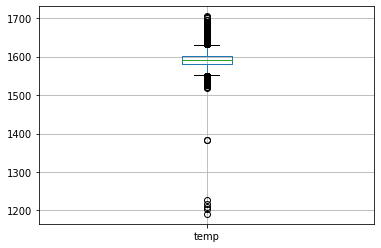

In [26]:

df_temp.boxplot(column='temp')
plt.show()

In [27]:
#df_temp = df_temp.query('temp > 1400')

In [28]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key     15907 non-null int64
time    15907 non-null datetime64[ns]
temp    13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


df_wire <b> Данные о проволочных материалах (объем)

In [29]:
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_wire = df_wire.fillna(0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdde6fc9b90>,
      dtype=object)

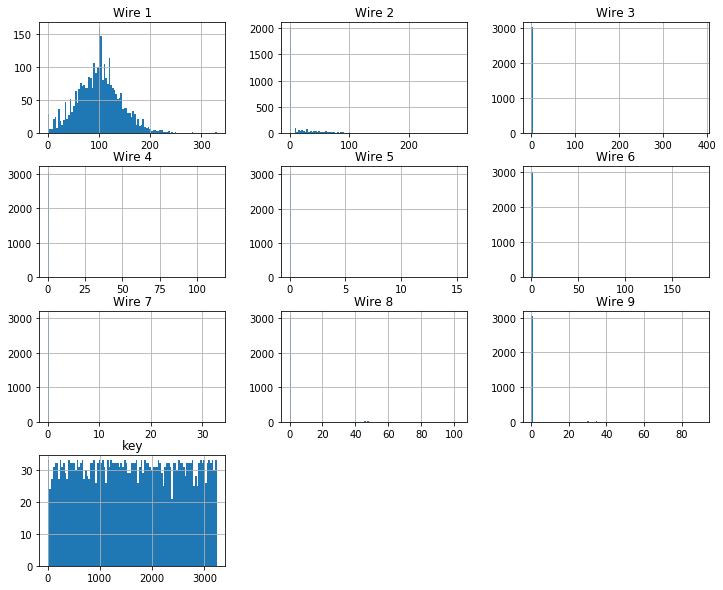

In [31]:
df_wire.hist(figsize = (12,10), bins= 100)

In [32]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3081 non-null float64
Wire 2    3081 non-null float64
Wire 3    3081 non-null float64
Wire 4    3081 non-null float64
Wire 5    3081 non-null float64
Wire 6    3081 non-null float64
Wire 7    3081 non-null float64
Wire 8    3081 non-null float64
Wire 9    3081 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


df_wire_time <b> Данные о проволочных материалах (время)

In [33]:
df_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


<h1> Создание целевого признака и зачистка таблиц от мусора

<b> Работа с таблицой df_temp

In [35]:
#Создадим сводную таблицу для определения начала и конца плавки для каждого сплава. 
df_temp_data = df_temp.pivot_table(index=['key'], values='time', aggfunc=['last', 'first']) #['max', 'min']
df_temp_data.columns = ['max', 'min']

In [36]:
df_temp_data

,max,min
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...
3237,2019-08-31 23:05:43,2019-08-31 22:44:04
3238,2019-08-31 23:43:00,2019-08-31 23:30:31
3239,2019-09-01 02:24:15,2019-09-01 01:31:47


In [37]:
#Отделим столбцы начала и конца плавки
datamin = df_temp_data['min']
datamax = df_temp_data['max']

In [38]:
#Соеденим их с основной таблицой df_temp по ключу 
final_temp_max = df_temp.merge(datamax, on = 'key')
final_temp_min = df_temp.merge(datamin, on = 'key')

In [39]:
#Создадим целевой признак из последних замеров
target = final_temp_max[final_temp_max["time"] == final_temp_max["max"]]
features = final_temp_min[final_temp_min["time"] == final_temp_min["min"]]

In [40]:
features 

,key,time,temp,min
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:16:18
5,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:37:27
11,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:13:17
16,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:52:57
19,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:23:19
...,...,...,...,...
15878,3237,2019-08-31 22:44:04,1569.0,2019-08-31 22:44:04
15883,3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:30:31
15886,3239,2019-09-01 01:31:47,1598.0,2019-09-01 01:31:47
15894,3240,2019-09-01 02:39:01,1617.0,2019-09-01 02:39:01


In [41]:
target

,key,time,temp,max
4,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:30:39
10,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:59:12
15,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:34:57
18,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:59:25
20,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:36:01
...,...,...,...,...
15882,3237,2019-08-31 23:05:43,NaN,2019-08-31 23:05:43
15885,3238,2019-08-31 23:43:00,NaN,2019-08-31 23:43:00
15893,3239,2019-09-01 02:24:15,NaN,2019-09-01 02:24:15
15901,3240,2019-09-01 03:35:16,NaN,2019-09-01 03:35:16


In [42]:
#Дропнем индексы
target = target.reset_index() #.dropna()
target= target.drop(['index', 'max'], axis=1)

In [43]:
features = features.reset_index() 
features= features.drop(['index', 'min'], axis=1)
features.columns = ['key_f', 'time_start', 'temp_start']

In [44]:
target

,key,time,temp
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
...,...,...,...
3211,3237,2019-08-31 23:05:43,NaN
3212,3238,2019-08-31 23:43:00,NaN
3213,3239,2019-09-01 02:24:15,NaN
3214,3240,2019-09-01 03:35:16,NaN


<b>Работа с таблицой df_arc

In [45]:
df_arc

,key,start,end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [46]:
#Просумируем значения столбцов по каждому кею 
df_arc_sum = df_arc.pivot_table(index=['key'], values=['active_power', 'reactive_power'], aggfunc='sum')
#df_temp_data.columns = ['max', 'min']

In [47]:
df_arc_sum = df_arc_sum .reset_index()


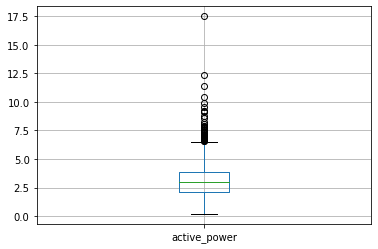

In [48]:
df_arc_sum.boxplot(column='active_power')
plt.show()

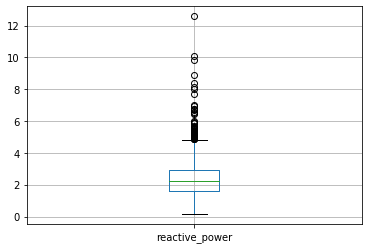

In [49]:
df_arc_sum.boxplot(column='reactive_power')
plt.show()

In [50]:
#Решил воспользоваться твоим советом и удалить выбросы выше q3+3iqr.
q3_a = np.percentile(df_arc_sum['active_power'], 75, interpolation = 'midpoint') 
q1_a = np.percentile(df_arc_sum['active_power'], 25, interpolation = 'midpoint') 
iqr_a = q3_a - q1_a 
  
print(q3_a + 3*iqr_a) 

9.2239947987


In [51]:
q3_r = np.percentile(df_arc_sum['reactive_power'], 75, interpolation = 'midpoint') 
q1_r = np.percentile(df_arc_sum['reactive_power'], 25, interpolation = 'midpoint') 
iqr_r = q3_r - q1_r 
  
print(q3_r + 3*iqr_r) 


6.7979215982


In [52]:
df_arc_sum = df_arc_sum.query('reactive_power <= 6.7979215982 and active_power <= 9.2239947987')

<h1> Создание основной таблицы

In [53]:
#Начинаем создание таблицы со всеми признаками
big_data = target
big_data['key_f'] = features['key_f']
big_data['time_start'] = features['time_start']
big_data['temp_start'] = features['temp_start']

In [54]:
big_data = big_data.dropna().reset_index()

In [55]:
#big_data = big_data.drop(['key','time','temp'], axis = 1)
big_data = big_data.drop(['key_f', 'index'], axis = 1)

In [56]:
big_data  = big_data.merge(df_gas, on='key', how='right')


In [57]:
big_data = big_data.dropna().reset_index(drop = True)

In [58]:
big_data  = big_data.merge(df_arc_sum, on='key', how='right')

In [59]:
big_data = big_data.dropna().reset_index(drop = True)

In [60]:
big_data  = big_data.merge(df_wire, on='key', how='right')
big_data = big_data.dropna().reset_index(drop = True)
big_data  = big_data.merge(df_bulk, on='key', how='right')
big_data = big_data.dropna().reset_index(drop = True)


In [61]:
big_data

,key,time,temp,time_start,temp_start,gas_1,active_power,reactive_power,Wire 1,Wire 2,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,29.749986,4.878147,3.183241,60.059998,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,12.555561,3.052598,1.998112,96.052315,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,28.554793,2.525882,1.599076,91.160157,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,18.841219,3.209250,2.060298,89.063515,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,5.413692,3.347173,2.252643,89.238236,9.11456,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,2495,2019-08-06 00:54:42,1591.0,2019-08-06 00:35:45,1570.0,7.125735,3.210690,2.360777,89.150879,0.00000,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2315,2496,2019-08-06 01:29:52,1591.0,2019-08-06 01:02:54,1554.0,9.412616,4.203064,2.810185,114.179527,0.00000,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2316,2497,2019-08-06 01:53:50,1589.0,2019-08-06 01:41:53,1571.0,6.271699,2.212379,1.851269,94.086723,9.04800,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2317,2498,2019-08-06 02:25:31,1594.0,2019-08-06 02:03:49,1591.0,14.953657,3.408725,2.355428,118.110717,0.00000,...,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0


In [62]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 32 columns):
key               2319 non-null int64
time              2319 non-null datetime64[ns]
temp              2319 non-null float64
time_start        2319 non-null datetime64[ns]
temp_start        2319 non-null float64
gas_1             2319 non-null float64
active_power      2319 non-null float64
reactive_power    2319 non-null float64
Wire 1            2319 non-null float64
Wire 2            2319 non-null float64
Wire 3            2319 non-null float64
Wire 4            2319 non-null float64
Wire 5            2319 non-null float64
Wire 6            2319 non-null float64
Wire 7            2319 non-null float64
Wire 8            2319 non-null float64
Wire 9            2319 non-null float64
Bulk 1            2319 non-null float64
Bulk 2            2319 non-null float64
Bulk 3            2319 non-null float64
Bulk 4            2319 non-null float64
Bulk 5            2319 non-null float64
B

<h1>Создание и обучение модели

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMRegressor
from sklearn.linear_model import LinearRegression

In [64]:
from catboost import CatBoostRegressor

In [65]:
big_data = big_data.drop(['time', 'time_start', 'key'], axis = 1)

In [66]:
big_data.columns

Index(['temp', 'temp_start', 'gas_1', 'active_power', 'reactive_power',
       'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 8', 'Wire 9', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5',
       'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [67]:
big_data.head(3)

,temp,temp_start,gas_1,active_power,reactive_power,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1613.0,1571.0,29.749986,4.878147,3.183241,60.059998,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,1602.0,1581.0,12.555561,3.052598,1.998112,96.052315,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,1599.0,1596.0,28.554793,2.525882,1.599076,91.160157,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0


In [68]:
#data_ohe = pd.get_dummies(big_data, drop_first=True)

#target = data_ohe['Exited']
#features = data_ohe.drop('Exited', axis=1)

data_train, data_valid = train_test_split(big_data, test_size=0.25, random_state=12345)



features_train = data_train.drop(['temp'], axis=1)
target_train = data_train['temp']

features_valid = data_valid.drop(['temp'], axis=1)
target_valid = data_valid['temp']

Feature ranking:
1. feature 4 (0.100087)
2. feature 0 (0.098642)
3. feature 2 (0.097875)
4. feature 1 (0.096276)
5. feature 3 (0.096133)
6. feature 26 (0.088148)
7. feature 24 (0.077321)
8. feature 27 (0.073028)
9. feature 15 (0.062259)
10. feature 5 (0.056728)
11. feature 16 (0.049011)
12. feature 18 (0.030780)
13. feature 13 (0.017451)
14. feature 22 (0.015045)
15. feature 23 (0.013774)
16. feature 17 (0.006376)
17. feature 9 (0.005165)
18. feature 12 (0.004244)
19. feature 6 (0.004215)
20. feature 25 (0.001824)
21. feature 11 (0.001414)
22. feature 21 (0.001229)
23. feature 19 (0.001203)
24. feature 7 (0.000724)
25. feature 14 (0.000618)
26. feature 10 (0.000247)
27. feature 20 (0.000182)
28. feature 8 (0.000000)


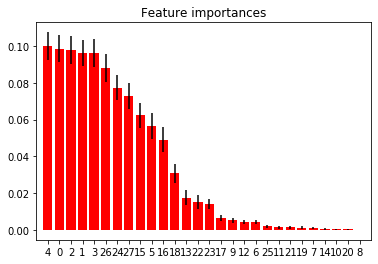

In [69]:
# Графика важности факторов



forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(features_train, target_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


print("Feature ranking:")

for f in range(features_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


plt.figure()
plt.title("Feature importances")
plt.bar(range(features_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(features_train.shape[1]), indices)
plt.xlim([-1, features_train.shape[1]])
plt.show()

In [70]:
features_train.head(3)

,temp_start,gas_1,active_power,reactive_power,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1497,1548.0,9.893686,4.235932,3.214491,52.182003,0.000000,0.0,0.0,0.0,0.0,...,68.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,351.0,103.0
359,1556.0,20.289447,6.706836,4.401988,121.305594,46.174957,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,411.0,0.0,275.0,152.0
1458,1565.0,12.418139,5.124028,3.204895,65.192406,60.108879,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,463.0,0.0,349.0,205.0


<b> Из графика можно сделать вывод, что 8 стобец не влияет на целевой признак, а значит от него можно смело избавляться. 

In [71]:
big_data.columns

Index(['temp', 'temp_start', 'gas_1', 'active_power', 'reactive_power',
       'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 8', 'Wire 9', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5',
       'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [72]:
#features_train = features_train.drop(['Wire 4', 'Wire 6','Wire 7','Bulk 1','Wire 3','Bulk 6','Bulk 7','Bulk 8'], axis=1)
#features_valid = features_valid.drop(['Wire 4', 'Wire 6','Wire 7','Bulk 1','Wire 3','Bulk 6','Bulk 7','Bulk 8'], axis=1)

#features_train = features_train.drop(['Wire 4'], axis=1)
#features_valid = features_valid.drop(['Wire 4'], axis=1)


In [73]:
model_d = DecisionTreeRegressor(random_state=12345, max_depth=6) 
model_d.fit(features_train, target_train)
predictions_valid = model_d.predict(features_valid)


mae = mean_absolute_error(target_valid, predictions_valid)
print(mae) 


6.864622693331735


In [74]:
model_l = LinearRegression() 
model_l.fit(features_train, target_train)
predictions_valid_l = model_l.predict(features_valid)


mae_l = mean_absolute_error(target_valid, predictions_valid_l)
print(mae_l) 


6.190981719141012


In [75]:
for i in range(7, 11):
    for b in range(80, 101):
        for c in range(50, 60):
            model = LGBMRegressor(random_state=12345, max_depth=i, n_estimators = c, iterations=b, learning_rate=0.1) 
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)

            print("max_depth =", i, 'iterations =', b,'n_estimators', c, end='')
            mae = mean_absolute_error(target_valid, predictions_valid)
            print('mae', mae) 

max_depth = 7 iterations = 80 n_estimators 50mae 6.031720492526904
max_depth = 7 iterations = 80 n_estimators 51mae 6.033087102943348
max_depth = 7 iterations = 80 n_estimators 52mae 6.032527036799207
max_depth = 7 iterations = 80 n_estimators 53mae 6.032941573557254
max_depth = 7 iterations = 80 n_estimators 54mae 6.0237863778901275
max_depth = 7 iterations = 80 n_estimators 55mae 6.01853707140324
max_depth = 7 iterations = 80 n_estimators 56mae 6.008023998859913
max_depth = 7 iterations = 80 n_estimators 57mae 6.007857323361944
max_depth = 7 iterations = 80 n_estimators 58mae 6.00710011681667
max_depth = 7 iterations = 80 n_estimators 59mae 6.010146684873519
max_depth = 7 iterations = 81 n_estimators 50mae 6.031720492526904
max_depth = 7 iterations = 81 n_estimators 51mae 6.033087102943348
max_depth = 7 iterations = 81 n_estimators 52mae 6.032527036799207
max_depth = 7 iterations = 81 n_estimators 53mae 6.032941573557254


KeyboardInterrupt: 

In [ ]:
for i in range(5, 11):
    for b in range(30, 101):
        model = CatBoostRegressor(random_state=12345, depth=i, iterations=b, learning_rate=0.01) 
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)

        print("max_depth =", i, 'iterations =', b, end='')
        mae = mean_absolute_error(target_valid, predictions_valid)
        print('mae', mae) 

max_depth = 7 iterations = 98 mae 6.1331448189425855

max_depth = 7 iterations = 98 mae 5.916994939600317 learning_rate = 0.1 

In [ ]:
for i in range(5, 20):
    for b in range(30, 100):
        model = RandomForestRegressor(max_depth = i, n_estimators = b, random_state=12345) 
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)

        print("max_depth =", i, 'n_estimators =', b, end='')
        mae = mean_absolute_error(target_valid, predictions_valid)
        print('mae', mae) 

max_depth = 14 n_estimators = 65mae 6.099643572112266

In [ ]:
model = RandomForestRegressor(max_depth = 13, n_estimators = 65, random_state=12345)
model.fit(features_train, target_train)
predict = model.predict(features_valid)
mae_rf = mean_absolute_error(target_valid, predict)
print(mae_rf)

In [76]:
model_cb = CatBoostRegressor(random_state=12345, depth=7, iterations=97, learning_rate=0.1) 
model_cb.fit(features_train, target_train)
predictions_valid_cb = model_cb.predict(features_valid)


mae_cb = mean_absolute_error(target_valid, predictions_valid_cb)
print(mae_cb)


0:	learn: 10.5763172	total: 51.5ms	remaining: 4.94s
1:	learn: 10.3021572	total: 54.3ms	remaining: 2.58s
2:	learn: 10.0694300	total: 57.6ms	remaining: 1.8s
3:	learn: 9.8630924	total: 60.6ms	remaining: 1.41s
4:	learn: 9.6224955	total: 63.4ms	remaining: 1.17s
5:	learn: 9.4410354	total: 66.1ms	remaining: 1s
6:	learn: 9.2612511	total: 155ms	remaining: 1.99s
7:	learn: 9.1005087	total: 158ms	remaining: 1.76s
8:	learn: 8.9496478	total: 161ms	remaining: 1.57s
9:	learn: 8.8248649	total: 164ms	remaining: 1.42s
10:	learn: 8.7165243	total: 253ms	remaining: 1.98s
11:	learn: 8.6004432	total: 258ms	remaining: 1.83s
12:	learn: 8.4900457	total: 261ms	remaining: 1.69s
13:	learn: 8.3865766	total: 264ms	remaining: 1.57s
14:	learn: 8.2956564	total: 351ms	remaining: 1.92s
15:	learn: 8.2242302	total: 354ms	remaining: 1.79s
16:	learn: 8.1285666	total: 357ms	remaining: 1.68s
17:	learn: 8.0519745	total: 360ms	remaining: 1.58s
18:	learn: 7.9862033	total: 449ms	remaining: 1.84s
19:	learn: 7.9108599	total: 455ms	re

<b> Вывод.
    
    Мы получили МАЕ в районе 5.9 на модели кэтбуст. Это было сделано с помощью объединения данных и зачистки их от аномалий. Очень сильно на результат влияли выбросы в таблице df_arc, если их не убирать, а значений там всего 6, то результат ухудшается  на 0.2. Также были предприняты попытки удалить столбцы, которые не влияют на целевую выборку, но результат ухудшался, так что я принял решения их оставить